# Problem Set #3

# Hyun Ki Kim

# 01/24/2018

In [1]:
import numpy as np
import numpy.linalg as lin
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as intgr
import scipy.optimize as opt

# 1. Some income data, lognormal distribution, and GMM

In [2]:
incomes = np.loadtxt("incomes.txt")

# (a)

Text(0,0.5,'Frequency')

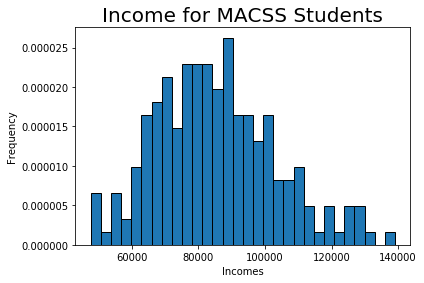

In [3]:
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title("Income for MACSS Students", fontsize=20)
plt.xlabel("Incomes")
plt.ylabel("Frequency")

# (b)

In [4]:
def lognorm_pdf(xvals, mu, sigma):
            
    pdf_vals    = (1/(xvals * sigma * np.sqrt(2 * np.pi) ) *
                   np.exp( - (np.log(xvals) - mu) ** 2 / (2 * sigma ** 2)))
    
    return pdf_vals

In [5]:
def data_moments(xvals):
    
    mean_data = xvals.mean()
    sd_data = np.sqrt(xvals.var())
  
    return mean_data, sd_data

In [6]:
def model_moments(mu, sigma):
    
    mean_model = np.exp(mu + sigma ** 2 / 2)
    var_model = np.exp(2 * mu + sigma ** 2) * (np.exp(sigma ** 2) - 1)
    
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

In [7]:
def err_vec(xvals, mu, sigma):
    
    mean_data, std_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [std_data]])
    
    mean_model, std_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [std_model]])

    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

In [8]:
def criterion(params, *args):
    
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [9]:
mu_init, sigma_init = data_moments(np.log(incomes))
params_init = np.array([mu_init, sigma_init])

W_hat = np.eye(2)
gmm_args = (incomes, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_ident_mat, sig_GMM_ident_mat = results.x

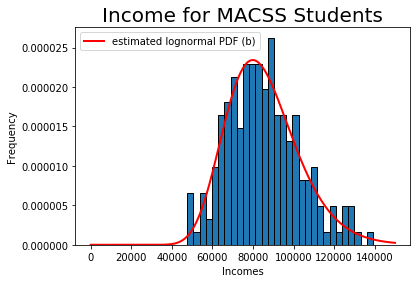

In [10]:
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title("Income for MACSS Students", fontsize=20)
plt.xlabel("Incomes")
plt.ylabel("Frequency")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='estimated lognormal PDF (b)')
plt.legend(loc='upper left')

In [11]:
print("GMM criterion function at the estimated parameter values:", results.fun[0])
print("Two data moments:", data_moments(incomes))
print("Two model moments:", model_moments(mu_GMM_ident_mat, sig_GMM_ident_mat))

GMM criterion function at the estimated parameter values: [  2.07488379e-11]
Two data moments: (85276.823606258113, 17992.542128046523)
Two model moments: (85277.158375889354, 17992.583697689046)


# (c)

In [12]:
err_firststep = err_vec(incomes, mu_GMM_ident_mat, sig_GMM_ident_mat)
VCV_2step = np.dot(err_firststep, err_firststep.T) / len(incomes)
W_hat_2step = lin.pinv(VCV_2step)

mu_init, sigma_init = data_moments(np.log(incomes))
params_init = np.array([mu_init, sigma_init])

W_hat = W_hat_2step
gmm_args = (incomes, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_2step, sig_GMM_2step = results.x

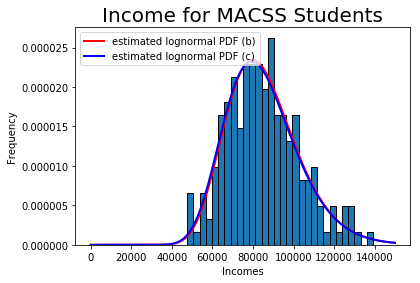

In [13]:
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title("Income for MACSS Students", fontsize=20)
plt.xlabel("Incomes")
plt.ylabel("Frequency")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='estimated lognormal PDF (b)')
plt.legend(loc='upper left')

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_2step, sig_GMM_2step),
         linewidth=2, color='b', label='estimated lognormal PDF (c)')
plt.legend(loc='upper left')

In [14]:
print("Estimates:", results.x)
print("GMM criterion function at the estimated parameter values:", results.fun[0])
print("Two data moments:", data_moments(incomes))
print("Two model moments:", model_moments(results.x[0], results.x[1]))

Estimates: [ 11.32586446   0.21167458]
GMM criterion function at the estimated parameter values: [ 0.00045164]
Two data moments: (85276.823606258113, 17992.542128046523)
Two model moments: (84818.378453149897, 18156.895846265455)


# (d)

In [15]:
def data_moments3(xvals):
    
    bpct_1_dat = xvals[xvals < 75000].shape[0] / xvals.shape[0]
    bpct_2_dat = (xvals[(xvals >= 75000) & (xvals <= 100000)].shape[0] /
                  xvals.shape[0])
    bpct_3_dat = xvals[xvals > 100000].shape[0] / xvals.shape[0]

    return bpct_1_dat, bpct_2_dat, bpct_3_dat

In [16]:
def model_moments3(mu, sigma):
    
    xfx = lambda x: lognorm_pdf(x, mu, sigma)
    (bpct_1_mod, bp_1_err) = intgr.quad(xfx, 1e-6, 75000 - 1e-6)
    (bpct_2_mod, bp_2_err) = intgr.quad(xfx, 75000, 100000)
    (bpct_3_mod, bp_3_err) = (1, 0) - intgr.quad(xfx, 1e-6, 100000) * np.array([1, -1])
    
    return bpct_1_mod, bpct_2_mod, bpct_3_mod

In [17]:
def err_vec3(xvals, mu, sigma):
    
    bpct_1_dat, bpct_2_dat, bpct_3_dat = data_moments3(xvals)
    
    moms_data = np.array([[bpct_1_dat], [bpct_2_dat], [bpct_3_dat]])
    
    bpct_1_mod, bpct_2_mod, bpct_3_mod = model_moments3(mu, sigma)
    moms_model = np.array([[bpct_1_mod], [bpct_2_mod], [bpct_3_mod]])
    
    err_vec = 100 * ((moms_model - moms_data) / moms_data)
    
    return err_vec

In [18]:
def criterion3(params, *args):
    
    mu, sigma = params
    xvals, W = args
    err = err_vec3(xvals, mu, sigma)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [19]:
mu_init, sigma_init = data_moments(np.log(incomes))
params_init = np.array([mu_init, sigma_init])

W_hat = np.eye(3)
gmm_args = (incomes, W_hat)

results = opt.minimize(criterion3, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_ident_mat, sig_GMM_ident_mat = results.x

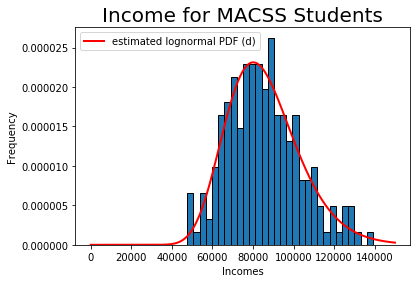

In [20]:
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title("Income for MACSS Students", fontsize=20)
plt.xlabel("Incomes")
plt.ylabel("Frequency")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, results.x[0], results.x[1]),
         linewidth=2, color='r', label='estimated lognormal PDF (d)')
plt.legend(loc='upper left')

In [21]:
print("GMM criterion function at the estimated parameter values:", results.fun[0])
print("Two data moments:", data_moments3(incomes))
print("Two model moments:", model_moments3(results.x[0], results.x[1]))

GMM criterion function at the estimated parameter values: [  2.53446197e-11]
Two data moments: (0.3, 0.5, 0.2)
Two model moments: (0.30000000362083074, 0.5000000058481757, 0.19999999050898098)


# (e)

In [22]:
err_firststep = err_vec(incomes, results.x[0], results.x[1])
VCV_2step = np.dot(err_firststep, err_firststep.T) / len(incomes)
W_hat_2step = lin.pinv(VCV_2step)

mu_init, sigma_init = data_moments(np.log(incomes))
params_init = np.array([mu_init, sigma_init])

W_hat = W_hat_2step
gmm_args = (incomes, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B', bounds=((None, None), (1e-10, None)))
mu_GMM_2step, sig_GMM_2step = results.x

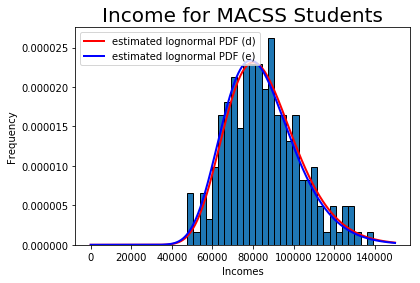

In [23]:
plt.hist(incomes, 30, edgecolor='black', normed=True)
plt.title("Income for MACSS Students", fontsize=20)
plt.xlabel("Incomes")
plt.ylabel("Frequency")

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_ident_mat, sig_GMM_ident_mat),
         linewidth=2, color='r', label='estimated lognormal PDF (d)')
plt.legend(loc='upper left')

dist_pts = np.linspace(0.1, 150000, 1000)
plt.plot(dist_pts, lognorm_pdf(dist_pts, mu_GMM_2step, sig_GMM_2step),
         linewidth=2, color='b', label='estimated lognormal PDF (e)')
plt.legend(loc='upper left')

In [24]:
print("Estimates:", results.x)
print("GMM criterion function at the estimated parameter values:", results.fun[0])
print("Three data moments:", data_moments3(incomes))
print("Three model moments:", model_moments3(results.x[0], results.x[1]))

Estimates: [ 11.3201824    0.21167451]
GMM criterion function at the estimated parameter values: [  3.93937743e-11]
Three data moments: (0.3, 0.5, 0.2)
Three model moments: (0.3268910950046711, 0.49184617620552695, 0.18126272876707761)


# (f)

In [25]:
criterion_values = {"(b)": 2.07488379e-11, "(c)": 0.00045164, "(d)": 2.53446197e-11, "(e)": 3.93937743e-11}
print(min(criterion_values, key=criterion_values.get))

(b)


There are no big difference between four estimates.
However, estimates from part (b) fits the data best because it has the lowest criterion function value.

# 2. Linear regression and GMM

In [26]:
sick = pd.read_csv("sick.txt")

# (a)

In [27]:
def data_moment(xvals):
    return xvals["sick"]

def model_moment(xvals, B0, B1, B2, B3):
    return B0 + B1 * xvals["age"] + B2 * xvals["children"] + B3 * xvals["avgtemp_winter"]

def err_vec(xvals, B0, B1, B2, B3):
    
    data_mom = data_moment(xvals)
    moms_data = np.array(data_mom)
    
    model_mom = model_moment(xvals, B0, B1, B2, B3)
    moms_model = np.array(model_mom)
    
    err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec

def criterion(params, *args):
    B0, B1, B2, B3 = params     
    xvals, W = args
    
    err = err_vec(xvals, B0, B1, B2, B3)
    crit_val = np.dot(np.dot(err.T, W), err) 
    
    return crit_val

In [28]:
params_init = np.array([1, 2, 3, 4])

W_hat = np.eye(200)
gmm_args = (sick, W_hat)

results = opt.minimize(criterion, params_init, gmm_args, method='L-BFGS-B')
B0, B1, B2, B3 = results.x

In [29]:
print("Estimated B0:", B0)
print("Estimated B1:", B1)
print("Estimated B2:", B2)
print("Estimated B3:", B3)
print("GMM criterion function at the estimated parameter values:", results.fun)

Estimated B0: 0.252223511918
Estimated B1: 0.0130231872958
Estimated B2: 0.399763551464
Estimated B3: -0.010060361831
GMM criterion function at the estimated parameter values: 0.0148567895123
